# Importing Libraries And Dataset

**Data description**

There are 3 types of input features:

* Objective: factual information;
* Examination: results of medical examination;
* Subjective: information given by the patient.

**Features:**

1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code |
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [3]:
!pip install lightgbm

In [39]:
import pandas as pd
import numpy as np
import math
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap

In [6]:
df_ = pd.read_csv("cardio_train.csv", sep=";")
df = df_.copy()
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
df =df.drop(columns='id')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.4 MB


In [8]:
# since the age is given in days, we convert it into years
df['age'] = df['age']/365
df['age'].astype(int)
df.isnull().sum()

,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,53.339358,6.759594,29.583562,48.394521,53.980822,58.430137,64.967123
gender,70000.0,1.349571,0.476838,1.000000,1.000000,1.000000,2.000000,2.000000
height,70000.0,164.359229,8.210126,55.000000,159.000000,165.000000,170.000000,250.000000
weight,70000.0,74.205690,14.395757,10.000000,65.000000,72.000000,82.000000,200.000000
ap_hi,70000.0,128.817286,154.011419,-150.000000,120.000000,120.000000,140.000000,16020.000000
ap_lo,70000.0,96.630414,188.472530,-70.000000,80.000000,80.000000,90.000000,11000.000000
cholesterol,70000.0,1.366871,0.680250,1.000000,1.000000,1.000000,2.000000,3.000000
gluc,70000.0,1.226457,0.572270,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,70000.0,0.088129,0.283484,0.000000,0.000000,0.000000,0.000000,1.000000
alco,70000.0,0.053771,0.225568,0.000000,0.000000,0.000000,0.000000,1.000000


## Catching Numerical and Categorical Variables

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and
                   dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                   dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 70000
Variables: 12
cat_cols: 7
num_cols: 5
cat_but_car: 0
num_but_cat: 7


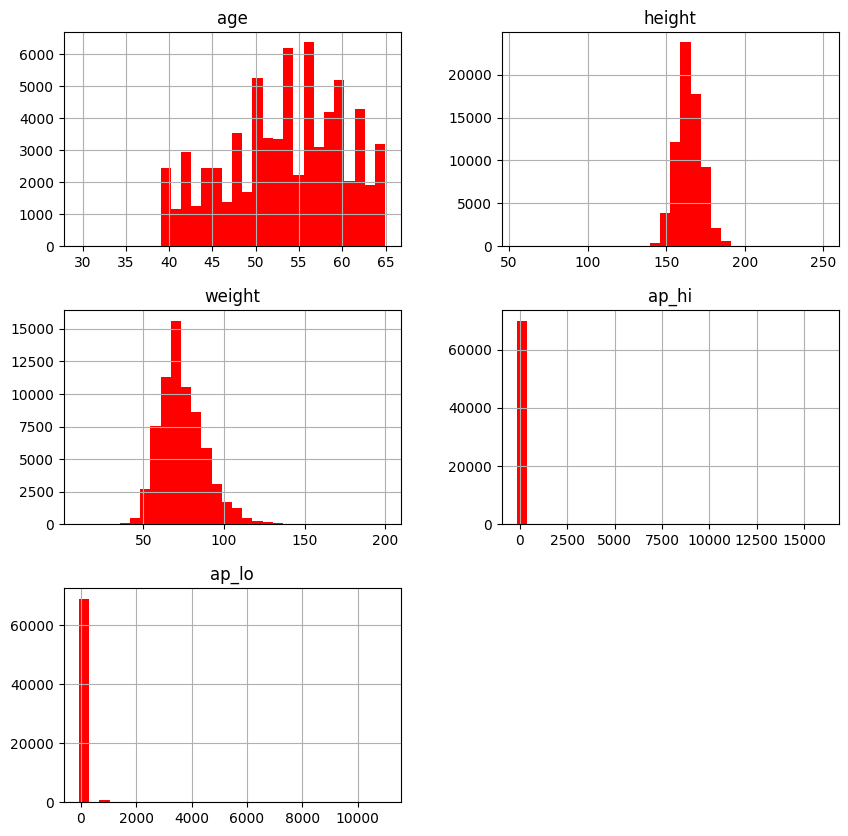

In [10]:
df[num_cols].hist(bins=30, figsize=(10,10), color='r')
plt.show()

In [13]:
df['ap_hi'].nunique(), df['ap_lo'].nunique()

(153, 157)

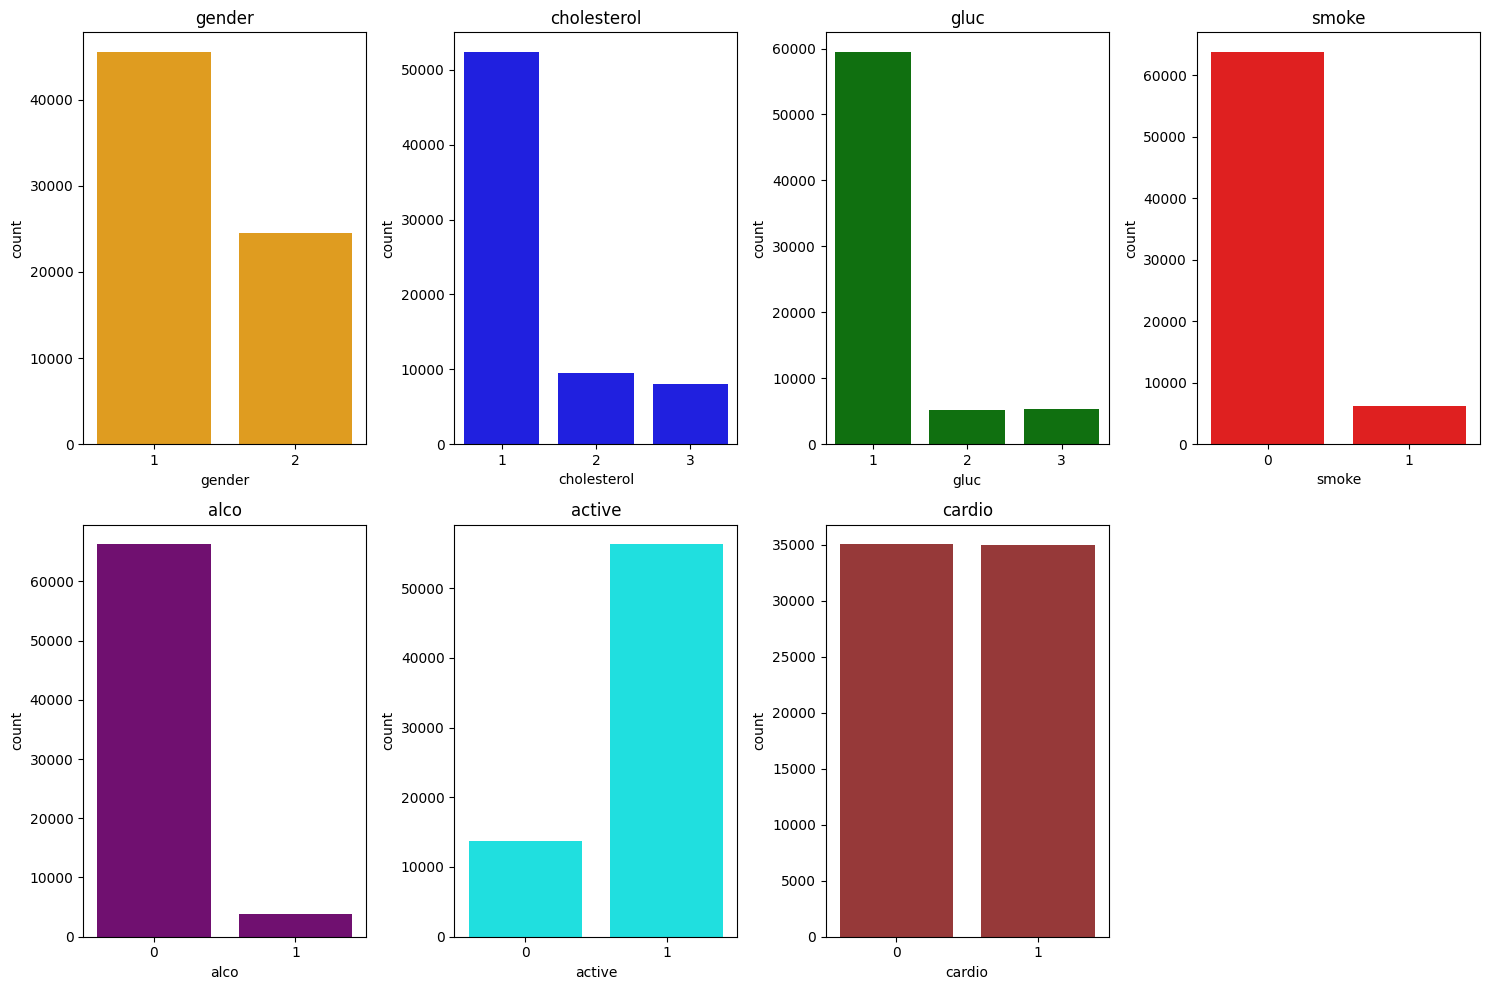

In [17]:
def cat_summary_multiple(dataframe, cat_cols, n_cols=3):
    colors = ['orange', 'blue', 'green', 'red', 'purple', 'cyan', 'brown']
    n_rows = math.ceil(len(cat_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.ravel()

    for i, col in enumerate(cat_cols):
        sns.countplot(x=dataframe[col], ax=axes[i], color=colors[i % len(colors)])
        axes[i].set_title(col)

    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cat_summary_multiple(df, cat_cols, n_cols=4)

# Outliers Problem

In [14]:
def outlier_thresholds(dataframe, col_name,  q1=0.05, q3=0.95):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    return low, up

In [16]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].shape[0] > 10:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].head(10))
    else:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )])
    if index:
      outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].index
      return outlier_index

number =1
for col in num_cols:
    print(number, '.', col.upper(), end='\n\n')
    grab_outliers(df, col)
    print()
    number += 1

1 . AGE

Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

2 . HEIGHT

             age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
224    59.726027       2      76    55.0    120     80            1     1   
3420   39.769863       1     100    70.0    100     70            1     1   
6486   58.136986       1     250    86.0    140    100            3     1   
7598   40.167123       2      70    72.0    120      8            1     1   
8171   48.345205       2      97   170.0    160    100            1     1   
11230  50.156164       1     110    90.0    120     80            1     1   
12770  53.682192       1      75   168.0    120     80            1     1   
13265  61.523288       2      71    68.0    120     80            3     1   
14323  60.287671       1      67    57.0    120     90            1     1   
15167  43.320548       1      70    68.0    120     80            1     1   

   

* Especially, Bloodpressure values such as AP_LO and AP_HI have outliers.

In [17]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

remove_outlier(df, 'height')
remove_outlier(df, 'weight')
remove_outlier(df, 'ap_hi')
remove_outlier(df, 'ap_lo')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52.712329,2,168,76.0,120,80,1,1,1,0,1,0
69996,61.920548,1,158,126.0,140,90,2,2,0,0,1,1
69997,52.235616,2,183,105.0,180,90,3,1,0,1,0,1
69998,61.454795,1,163,72.0,135,80,1,2,0,0,0,1


# Feature Engineering

In [12]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0


In [21]:
df['Bmi'] = df['weight'] / df['height']**2
df.loc[df['Bmi'] < 18.5, 'cat_bmi'] = 'Low'
df.loc[(df['Bmi'] >= 18.5) & (df['Bmi'] < 25), 'cat_bmi'] = 'Normal'
df.loc[(df['Bmi'] >= 25) & (df['Bmi'] < 30), 'cat_bmi'] = 'High'
df.loc[df['Bmi'] >= 30, 'cat_bmi'] = 'Very High'
df['Bmi_age'] = df['Bmi'] * df['age']
df['cat_age'] = pd.qcut(df['age'], 4)

## Correlation Matrix

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 70000
Variables: 16
cat_cols: 9
num_cols: 7
cat_but_car: 0
num_but_cat: 8


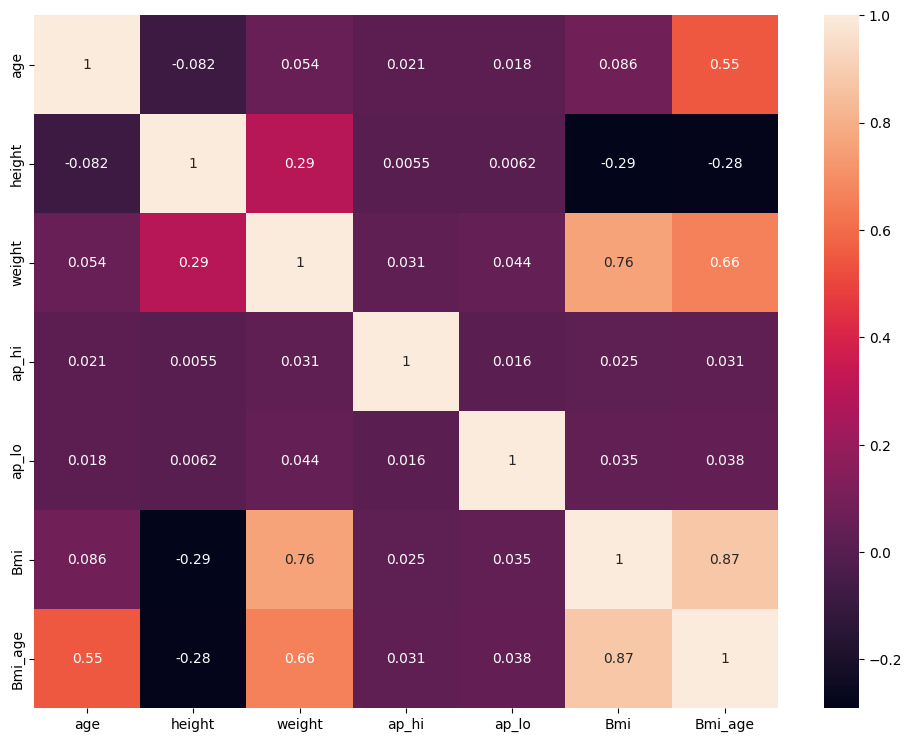

In [25]:
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Encoding

In [29]:
cat_cols = [col for col in cat_cols if col not in ['cardio']]

In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

# Scaling

In [31]:
X_scaled = MinMaxScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)
df.head()

,age,height,weight,ap_hi,ap_lo,cardio,Bmi,Bmi_age,gender_2,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke_1,alco_1,active_1,"cat_age_(48.395, 53.981]","cat_age_(53.981, 58.43]","cat_age_(58.43, 64.967]"
0,0.588076,0.579487,0.273684,0.016079,0.013550,0,0.062655,0.054089,True,False,False,False,False,False,False,True,True,False,False
1,0.730159,0.517949,0.394737,0.017934,0.014453,1,0.106560,0.102931,False,False,True,False,False,False,False,True,False,True,False
2,0.624003,0.564103,0.284211,0.017316,0.012647,1,0.067874,0.060426,False,False,True,False,False,False,False,False,True,False,False
3,0.528455,0.584615,0.378947,0.018553,0.015357,1,0.085498,0.070547,True,False,False,False,False,False,False,True,False,False,False
4,0.516918,0.517949,0.242105,0.015461,0.011743,0,0.066192,0.053775,False,False,False,False,False,False,False,False,False,False,False


# Training And Testing  Dataset

In [34]:
y = df['cardio'].values
X = df.drop('cardio', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 18), (14000, 18), (56000,), (14000,))

## Model

In [41]:
models = [#('LR', LogisticRegression(random_state=123)),
          #('KNN', KNeighborsClassifier()),
          #('CART', DecisionTreeClassifier(random_state=123)),
          ('RF', RandomForestClassifier(random_state=123)),
          #('SVM', SVC(gamma='auto', random_state=123)),
          #('XGB', XGBClassifier(random_state=123)),
          ("LightGBM", LGBMClassifier(random_state=123)),
          #("CatBoost", CatBoostClassifier(verbose=False, random_state=1))
          ]

for name, model in models:
    cv_results = cross_validate(
        model, X, y, cv=10, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall']
    )
    print(f"###  {name}  ###")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"F1 Score: {round(cv_results['test_f1'].mean(), 4)}")
    print(f"Roc_Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")

###  RF  ###
Accuracy: 0.7153
F1 Score: 0.7104
Roc_Auc: 0.7773
Precision: 0.7225
Recall: 0.6987
[LightGBM] [Info] Number of positive: 31482, number of negative: 31518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499714 -> initscore=-0.001143


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Start training from score -0.001143


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 31481, number of negative: 31519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001206
[LightGBM] [Info] Start training from score -0.001206
###  LightGBM  ###
Accuracy: 0.7362
F1 Score: 0.7255
Roc_Auc: 0.8032
Precision: 0.7558
Recall: 0.6976


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

# Hyperparameter Optimization

In [44]:
rf_params = {"max_depth": [8,    None],
             "max_features": [6, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [100, 200]}


lightgbm_params = {"learning_rate": [0.01, 0.1],
                  "n_estimators": [300, 500]}


classifiers = [#('KNN', KNeighborsClassifier(), knn_params),
               #("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
              ('LightGBM', LGBMClassifier(), lightgbm_params)
             ]



def hyperparameter_optimization(X, y, cv=3, scoring='accuracy'):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## RF ##########
accuracy (Before): 0.7178


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

accuracy (After): 0.735
RF best params: {'max_depth': 8, 'max_features': 6, 'min_samples_split': 20, 'n_estimators': 200}

########## LightGBM ##########
[LightGBM] [Info] Number of positive: 23319, number of negative: 23347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 46666, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499700 -> initscore=-0.001200
[LightGBM] [Info] Start training from score -0.001200


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 23320, number of negative: 23347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 46667, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499711 -> initscore=-0.001157
[LightGBM] [Info] Start training from score -0.001157


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 23319, number of negative: 23348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 46667, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499689 -> initscore=-0.001243
[LightGBM] [Info] Start training from score -0.001243


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

accuracy (Before): 0.7359


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 34979, number of negative: 35021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499700 -> initscore=-0.001200
[LightGBM] [Info] Start training from score -0.001200


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 23319, number of negative: 23347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 46666, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499700 -> initscore=-0.001200
[LightGBM] [Info] Start training from score -0.001200


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 23320, number of negative: 23347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 46667, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499711 -> initscore=-0.001157
[LightGBM] [Info] Start training from score -0.001157


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 23319, number of negative: 23348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 46667, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499689 -> initscore=-0.001243
[LightGBM] [Info] Start training from score -0.001243


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


accuracy (After): 0.7365
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



# CONCLUDE

* RF Accuracy (After Hyperparametre Optimization): 0.735
* RF best params: {'max_depth': 8, 'max_features': 6, 'min_samples_split': 20, 'n_estimators': 200}
* LightGBM Accuracy (After Hyperparametre Optimization): 0.7365
* LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}

* I think we need a dataset with more variables for our model to work better.
* **For example, variables that include genetic factors and tell us if there is such a disease in the family may give more successful results.**